In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import DataPreProcess
import statsmodels.api as sm
import warnings
import Visualization
warnings.filterwarnings("ignore")

# 数据导入
# 定义数据的位置
# 2013-11、2013-12是米兰市100*100网络中心的20*20的网络数据
# 2013-11-fusion、2013-12-fusion是将100*100网络聚合成20*20网络之后的数据

total_data_path = './Data/total.vocab'
data_11 = './Data/2013-11-fusion.vocab'
data_12 = './Data/2013-12-fusion.vocab'
max_min_path = './Data/loc_max_mix.vocab'

In [11]:
# 处理缺失值
data_without_missing_value = DataPreProcess.ProcessMissingValue(data_11, data_12, city_amount=400, judge_num=7)

# 处理异常值
data_without_abnormal_value = DataPreProcess.ProcessAbnormalValue(data_without_missing_value, city_amount=400, judge_week_num=8, judge_day_num=30)

total_data = data_without_abnormal_value.reshape(60, 400, 24)

There are 122 missing datas
There are 3364 abnormal num


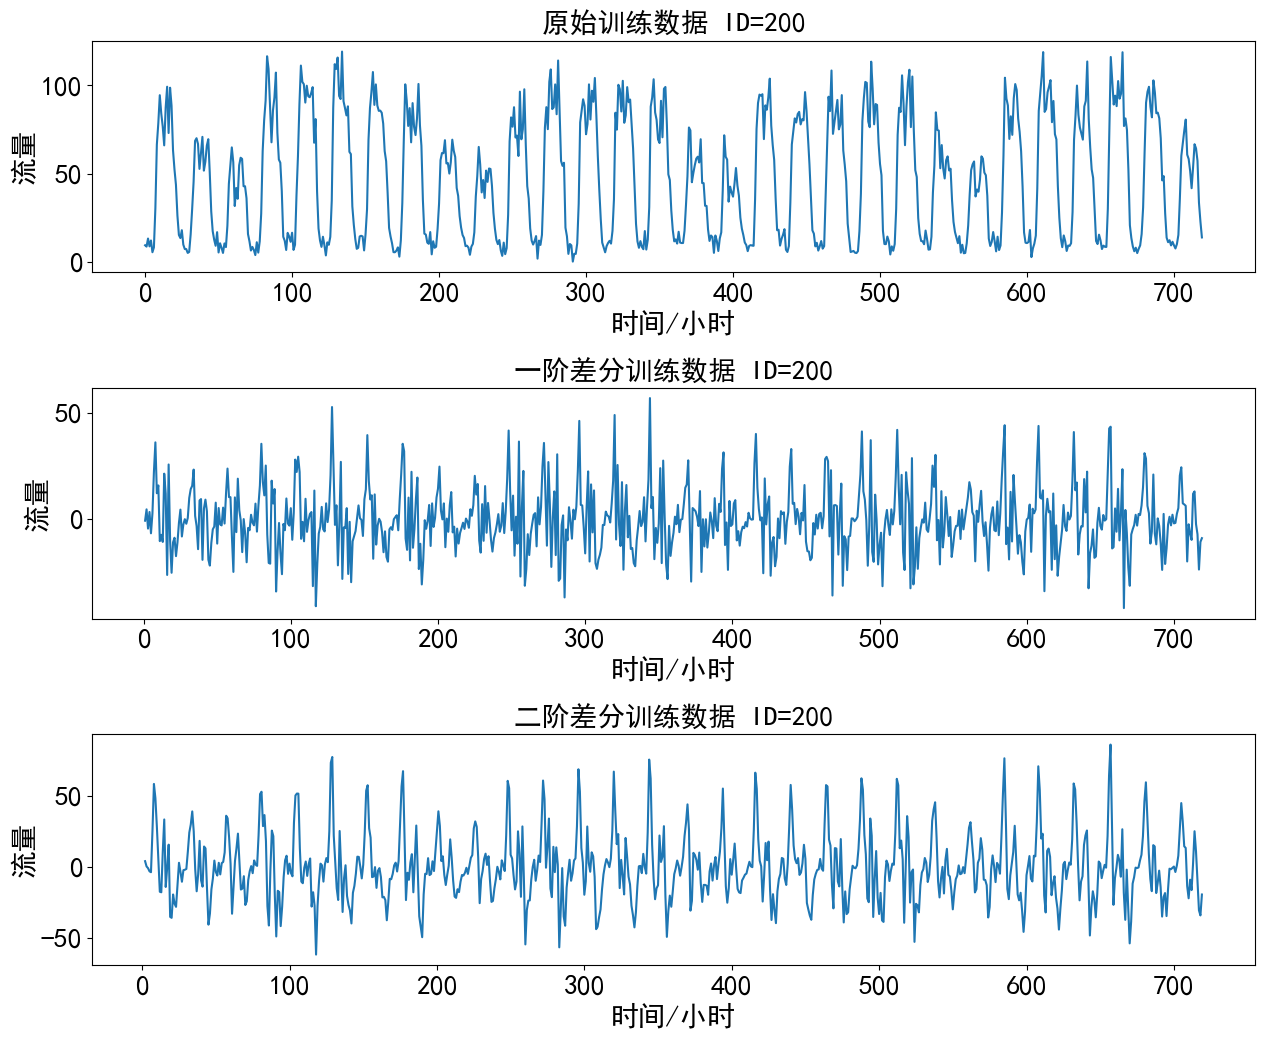

In [12]:
#选取ID=200的栅格区域
id = 200
#选取第7天-第43天的数据，7-36:训练集 37-43:测试集
base_timeseries = pd.Series(total_data[7:44,id,:].reshape(888))
train = base_timeseries[0:720]
test = base_timeseries[720:888]
train.head()

# 模型参数选择 p,d,q
# 1 差分处理，确定d
# 2 画ACF和PACF图，确定p,q

# 确定时间序列的差分
fig = plt.figure(figsize=(15,12))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['font.serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

# 原始数据
ax0= fig.add_subplot(311)
train.plot(ax=ax0)
ax0.set_xlabel('时间/小时', fontsize=20)
ax0.set_ylabel('流量', fontsize=20)
ax0.set_title('原始训练数据 ID=%d' %(id), fontsize=20)
ax0.tick_params(axis='x', labelsize=20)  # 设置 x 轴刻度标签的字体大小
ax0.tick_params(axis='y', labelsize=20)  # 设置 y 轴刻度标签的字体大小

# 经过1次/2次差分处理后的数据
ax1= fig.add_subplot(312)
diff1 = train.diff(1)
diff1.plot(ax=ax1)
ax1.set_xlabel('时间/小时', fontsize=20)
ax1.set_ylabel('流量', fontsize=20)
ax1.set_title('一阶差分训练数据 ID=%d' %(id), fontsize=20)
ax1.tick_params(axis='x', labelsize=20)  # 设置 x 轴刻度标签的字体大小
ax1.tick_params(axis='y', labelsize=20)  # 设置 y 轴刻度标签的字体大小
ax2= fig.add_subplot(313)
diff2 = train.diff(2)
diff2.plot(ax=ax2)
ax2.set_xlabel('时间/小时', fontsize=20)
ax2.set_ylabel('流量', fontsize=20)
ax2.set_title('二阶差分训练数据 ID=%d' %(id), fontsize=20)
ax2.tick_params(axis='x', labelsize=20)  # 设置 x 轴刻度标签的字体大小
ax2.tick_params(axis='y', labelsize=20)  # 设置 y 轴刻度标签的字体大小

plt.subplots_adjust(hspace=0.5)
plt.savefig('./results/5-4-2.svg', format='svg')
plt.show()

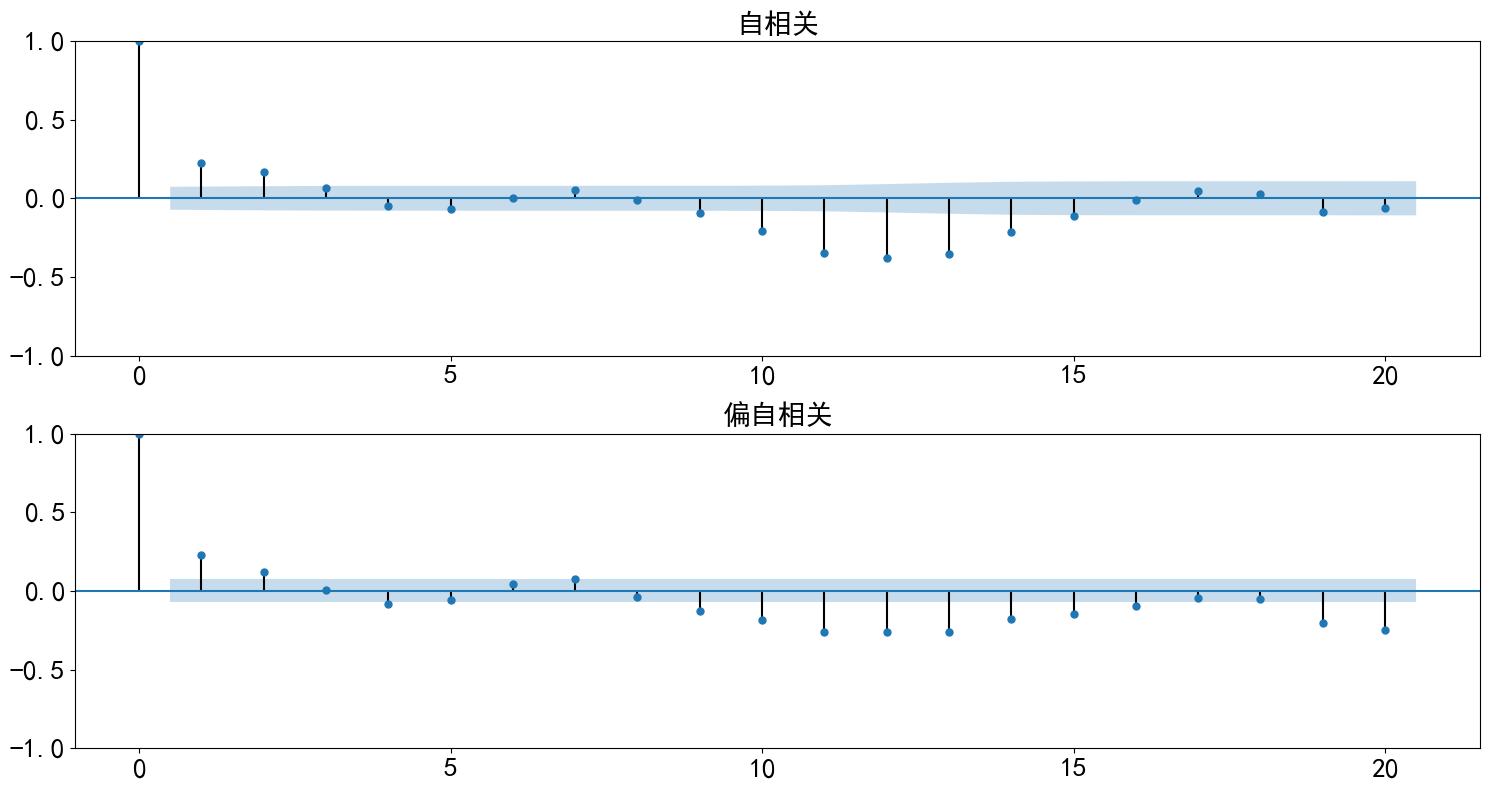

In [13]:
# 分别画出ACF(自相关)和PACF（偏自相关）图像

fig = plt.figure(figsize=(15,8))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['font.serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
#ACF(自相关)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1.dropna(), lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title('自相关', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)  # 设置 x 轴刻度标签的字体大小
ax1.tick_params(axis='y', labelsize=20)  # 设置 y 轴刻度标签的字体大小
fig.tight_layout()
#ACF（偏自相关）
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1.dropna(), lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('偏自相关', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)  # 设置 x 轴刻度标签的字体大小
ax2.tick_params(axis='y', labelsize=20)  # 设置 y 轴刻度标签的字体大小
fig.tight_layout()
plt.savefig('./results/5-4-3.svg', format='svg')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [03:24<00:00,  1.21s/it]


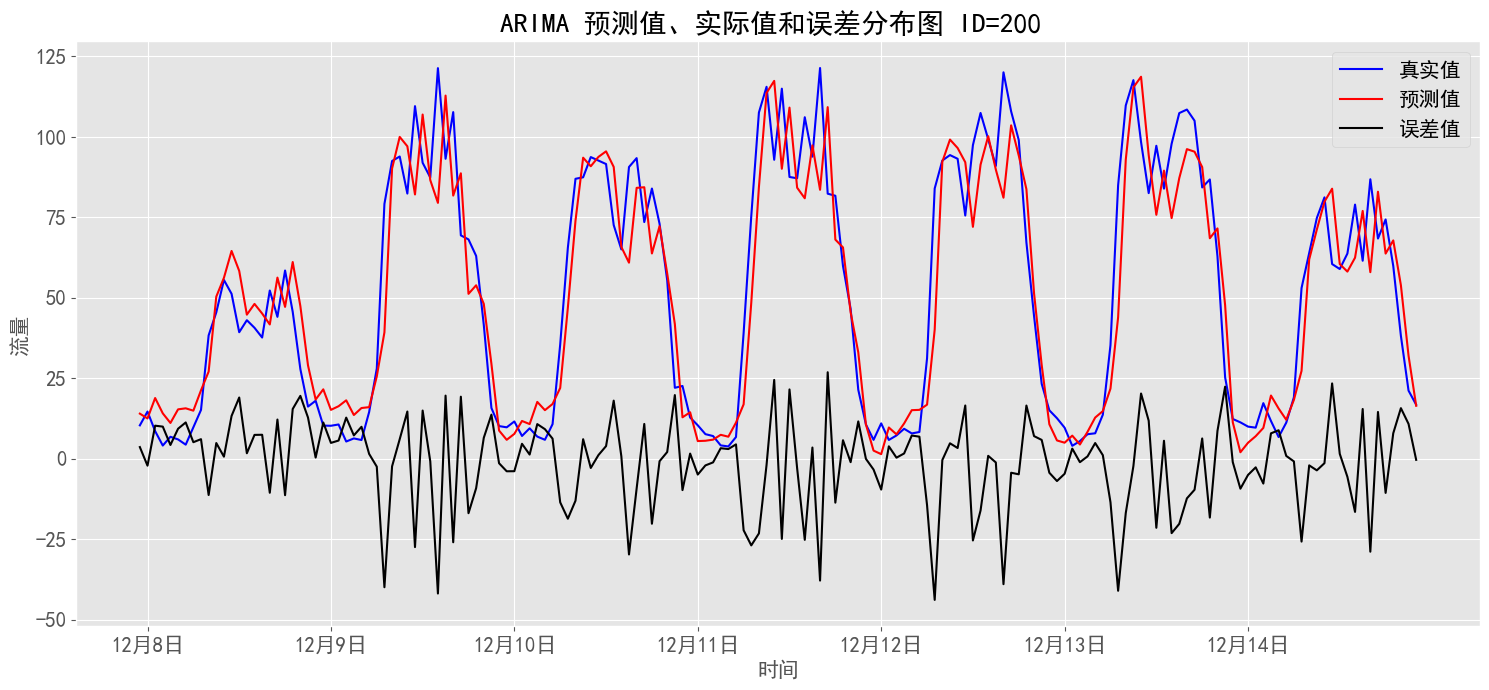

In [15]:
# arima算法 从statsmodels库中调用ARIMA算法实例
# 输入历史数据train_data，预测数据test_data和（p，d，q）顺序的order
# 输出为预测结果predictions_f
def arima_predict(train_data, test_data, order):
    history = train_data
    predictions_f = []
    for t in tqdm(range(len(test_data))):
        model = sm.tsa.ARIMA(history, order=order,
                             # history表示观察到的时间序列过程y。
                             # order表示自回归，差异和移动平均值分量的模型的（p，d，q）顺序。 d始终是整数，而p和q可以是整数或整数列表。
                             )
        model_fit = model.fit()
        yhat_f = model_fit.forecast()[0]
        predictions_f.append(yhat_f)
        history.append(test_data[t])
    return predictions_f


#这里选用(3,0,2)的（p，d，q）顺序进行实验，实际实验时可选取不同的order对结果进行观测并分析原因。
predict_value = arima_predict(train.values.tolist(),test.values.tolist(),(3,0,2))
predict_value = pd.Series(predict_value,index=test.index)

# 绘图设置
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

#预测结果可视化
plt.figure(figsize=(15,7))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['font.serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(np.arange(len(test.index)), test.values, color='b', label='真实值')
plt.plot(np.arange(len(predict_value.index)), predict_value, color='r', label='预测值')
plt.plot(np.arange(len(predict_value.index)), predict_value - test.values, color='k', label='误差值')
dt = list(range(len(predict_value)))
date = ['12月8日', '12月9日', '12月10日', '12月11日', '12月12日', '12月13日', '12月14日']
plt.xticks(range(1, len(dt), 24), date, rotation=0)
plt.title("ARIMA 预测值、实际值和误差分布图 ID=%d " %(id), fontsize=20)
plt.xlabel("时间", fontsize=15)
plt.ylabel("流量", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('./results/5-4-4.svg', format='svg')
plt.show()

In [16]:
#性能结果
RMSE =Visualization.CalculateRMSE(predict_value.to_numpy().reshape((-1, 1)), test.to_numpy().reshape((-1, 1)))
MAE = Visualization.CalculateMAE(predict_value.to_numpy().reshape((-1, 1)), test.to_numpy().reshape((-1, 1)))
R2 = Visualization.CalculateR2score(predict_value.to_numpy().reshape((-1, 1)), test.to_numpy().reshape((-1, 1)))

print('ARIMA -> RMSE: %f.  MAE: %f.  R2_score: %f.' % (RMSE, MAE, R2))

ARIMA -> RMSE: 14.285338.  MAE: 10.638615.  R2_score: 0.831321.
